<a href="https://colab.research.google.com/github/sseyonafre/Project/blob/main/sprint2/AI_14_%E1%84%80%E1%85%A9%E1%84%89%E1%85%A6%E1%84%92%E1%85%B4_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *DATA SCIENCE / SECTION 2 / PROJECT*

#  🏆 프로젝트 목표
>### kbo 승패예측 모델을 만들고 현재기대순위와 지금 순위를 비교해본다.

## 프로젝트 개요
###1. 문제정의 

>2022년 7월 22일 현재 시즌 전반기가 끝난상황, 모든 팀의 최소목표는 포스트시즌 진출(5위)이다. 
>
>전체 경기의 60%정도 진행된 상황에서 결과를 예측해보고 이에따라 하반기 팀의 전체적인 운용 방향이 크게 달라질 수 있다.
>
>현재 가을야구진출이 불투명한 상황. 확실한 가을야구 진출을 위해서 우리가 어떤 점을 보완할 수 있을 지 알아보려한다.


###2. 프로젝트의 전체적인 순서계획.

> 시즌 순위를 예측하기 위해서 '연'(year)단위 즉, 해당시즌 팀타격기록으로 순위를 예측하면 좋겠지만 데이터의 크기가 너무 작기때문에 매 경기단위로 데이터를 쪼개서 승패여부를 판별한 후, 예측된 승패로 계산된 승률을 토대로 순위 도출.


###3. 타겟정하기

>승리여부 (승리:1, 패:0) -> **분류**
>
>기준모델 : 타겟의 최빈값 -> 0
>
>승리여부와 관계있는 특성은 아무래도 타격은 장타율, 출루율, 투수는 방어율 

###4. 모델링
>로지스틱회귀, 랜덤포레스트,XGBoost, lihgtGBM 모델을 만들어본다.


#  ⚾️ Data Description
* `game_id` : 경기날짜 + 홈팀+ 원정팀 + 더블헤더유무
* `date`: 경기날짜
* `team` : 팀이름
* `vs` : 상대팀
* `home` : 홈경기 여부
* `PA` : 타석수
* `AB `: 타수 (타석에서 희생타, 볼넷, 몸맞는공 등을 제외)
* `RBI`: 타점 (Run Batted In)
* `RUN` : 득점 
* `HIT `: 총 안타수
* `H2`: 2루타
* `H3`: 3루타
* `HR`: 홈런
* `SB`: 도루성공
* `CS`: 도루실패 
* `SF`: 희생플라이
* `BB` : 볼넷
* `HP `: 몸에 맞는 공 ( hit by pitch)
* `K `: 삼진당한 횟수
* `GD`: 더블플레이 (병살당한 횟수)
* `LOB` : 잔루 (left on base)
* `RISP`: 득점권 타율
* `P_AB_CN `: 득점권 상황
* `P_HIT_CN `: 득점권 상황에서의 안타갯수
* `OBP `: 출루율 (on base rate)
* `avg` : 타율 
* `win `: 승리


#  데이터 탐색


## **1. Gathering Data**

In [119]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [120]:
!pip install pandas-profiling==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [121]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [122]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import eli5
import shap

In [124]:
#https://www.kaggle.com/datasets/park123/korea-baseball-datasetkbo-20152020
#여기서 2015~2020년까지의 데이터 수집한 후
#2021,22년의 데이터는 캐글에 올려진 깃헙에서 연도만 바꿔서 추가수집. 

In [125]:
from google.colab import files
uploaded = files.upload()

Saving baseball.csv to baseball (1).csv


In [126]:
#n233a 에서 2015년부터 2022년 까지 데이터를 전부 concat으로 합쳐서 하나의 데이터셋으로 만듦.

## **2. 데이터 탐색 및 정제**

In [127]:
df = pd.read_csv('baseball.csv',index_col=0)

In [128]:
#n233a 에서 컬럼이름도 수정하고, 팀이름도 수정하고 필요없는 컬럼 드랍까지 완료한 데이터셋임.

In [129]:
df.head()

,game_id,date,team,vs,home,PA,AB,RBI,RUN,HIT,...,HP,K,GD,LOB,RISP,P_AB_CN,P_HIT_CN,OBP,avg,win
0,20150328HHNE0,20150328,한화,넥센,T,54.0,42.0,4.0,4.0,10.0,...,1.0,7.0,0.0,24.0,0.133333,15,2,0.352941,0.238095,0.0
1,20150328NEHH0,20150328,넥센,한화,B,46.0,40.0,5.0,5.0,8.0,...,0.0,7.0,1.0,18.0,0.090909,11,1,0.304348,0.200000,1.0
2,20150328KTLT0,20150328,KT,롯데,T,46.0,35.0,8.0,9.0,14.0,...,1.0,8.0,1.0,23.0,0.285714,14,4,0.511111,0.400000,0.0
3,20150328LTKT0,20150328,롯데,KT,B,42.0,37.0,12.0,12.0,14.0,...,1.0,8.0,1.0,17.0,0.437500,16,7,0.439024,0.378378,1.0
4,20150328LGHT0,20150328,LG,KIA,T,34.0,29.0,1.0,1.0,7.0,...,0.0,6.0,2.0,17.0,0.200000,10,2,0.333333,0.241379,0.0


In [130]:
#train :2015~2020 시즌, val: 2021시즌 test:2022상반기.

train = df.query('20150101<date<20210101')
val = df.query('date >20210101')
test = df.query('date >20220101')

In [131]:
train.shape ,val.shape, test.shape

((8656, 27), (2286, 27), (846, 27))

#Feature Engineering

In [132]:
#n233a 에서 game_id를 새로 만듦. 
#원래는 날짜+홈팀+원정팀+더블헤더유무여서, 기아와 삼성의 게임이면 기아기준 row 와 삼성기준row 의 gameid가 같아버림.
#그래서 날짜+팀+상대팀+더블헤더유무 로 바꿈.

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

ImportError: ignored

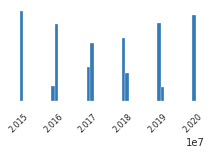

In [133]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

In [134]:
pd.options.mode.chained_assignment = None  # default='warn' ,warn 무시.

def eda(df):
    """특성을 엔지니어링 하는 함수입니다."""

    #안타율은 2루타, 3루타 홈런에 대한 가중치가 없으니까 가중치를 줘서 장타율을 만들자.
    #총 밟은 베이스 수로 가중치를 주면 됨. 그래서 hit + h2 + 2*h3 +3*hr /AB 로 구함.
    df['SLG'] = (df['HIT']+ df['H2']+ df['H3']*2 + df['HR']*3) /df['AB']

    #OPS: 출루율과 장타율을 더해줌 -> 공격기여를 한번에 확인할 수 있는 가장 유명한 지표.
    df['OPS']= df['OBP']+df['SLG']
    df['win']=df['win'].replace(0.5,0)       #다중분류가 아닌 이진분류를 위해 무승부를 패로 처리
    df['home']=df['home'].replace({'T':0,'B':1})   
    df.drop(columns=['P_AB_CN','P_HIT_CN','date'],inplace=True)
    for i in ['PA', 'AB', 'RBI', 'RUN',
       'HIT', 'H2', 'H3', 'HR', 'SB', 'CS', 'SF', 'BB', 'HP', 'K', 'GD', 'LOB','win']:
       df[i]= df[i].astype(int)

    return df

train = eda(train)
val = eda(val)
test = eda(test)    

###데이터 누수방지

feature에 대한 분석을 해보자.

In [136]:
train.columns

Index(['game_id', 'team', 'vs', 'home', 'PA', 'AB', 'RBI', 'RUN', 'HIT', 'H2',
       'H3', 'HR', 'SB', 'CS', 'SF', 'BB', 'HP', 'K', 'GD', 'LOB', 'RISP',
       'OBP', 'avg', 'win', 'SLG', 'OPS'],
      dtype='object')

game_id, date 는 제외하고 나머지 피쳐에 대한 분석을 해보면 
>* 수치형 :
       'PA', 'AB', 'RBI', 'RUN','HIT', 'H2', 'H3', 'HR', 'SB', 'CS', 'SF', 
       'BB', 'HP', 'K', 'GD', 'LOB','RISP','OBP', 'avg', 'SLG', 'OPS'
>* 명목형 : 
         'vs'
>* 이산형 : 
         'home'
         


In [137]:
numerical_features = ['PA', 'AB', 'RBI', 'RUN','HIT', 'H2', 'H3', 'HR', 'SB', 'CS', 'SF', 
 'BB', 'HP', 'K', 'GD', 'LOB','RISP','OBP', 'avg', 'SLG', 'OPS']

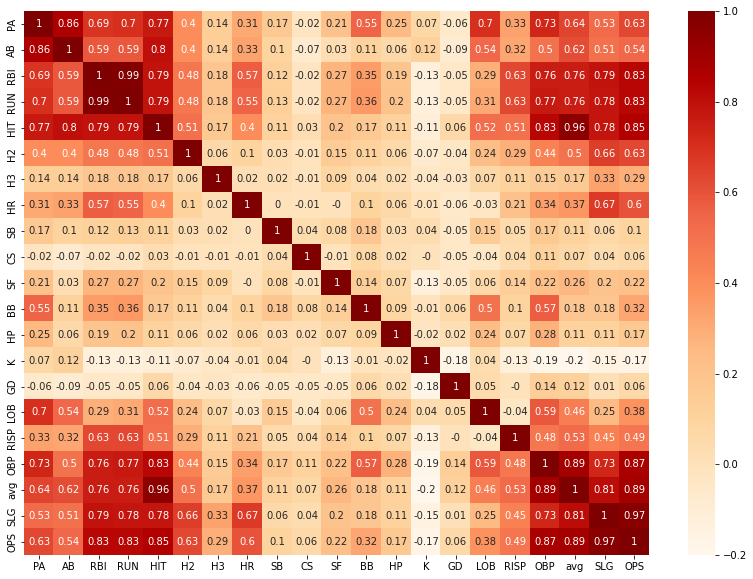

In [138]:
#수치형 변수들의 상관관계.
%matplotlib inline
corr = round(train[numerical_features].corr(),2)
plt.figure(figsize=(14,10))
sns.heatmap(corr,annot=True, cmap='OrRd');

In [139]:
#PA 와 AB는 제외할거니까 생각하지 않아도 됨. 
#타점과 득점은 상관관계가 0.99로 높음. 둘 중 하나는 제거.
#OPS 와 장타율 역시 상관관계가 높음. 

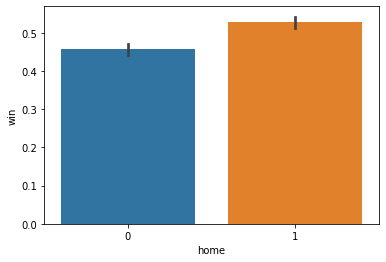

In [140]:
# home 피쳐의 타겟 분포 확인.
sns.barplot(x='home',y='win',data=train);

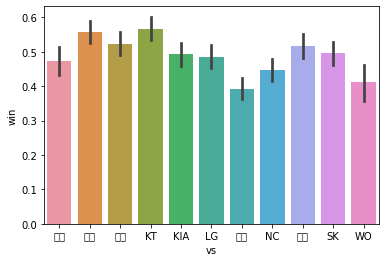

In [141]:
sns.barplot(x='vs',y='win',data=train); #고유값들에 대한 타겟값이 별 차이없음 -> 컬럼삭제.

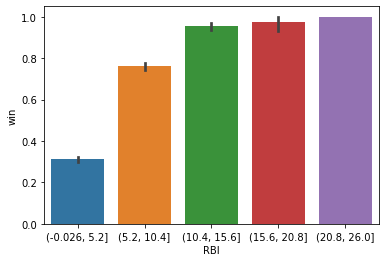

In [142]:
train['RBI'] = pd.cut(train['RBI'], 5)
sns.barplot(x='RBI', y='win', data=train);

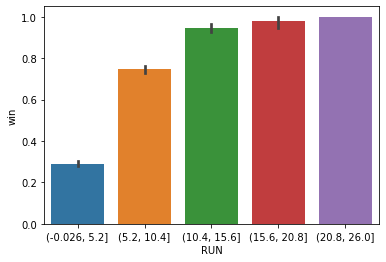

In [143]:
train['RUN'] = pd.cut(train['RUN'], 5)              #RBI 와 RUN 은 상관관계가 높으니 둘 중 하나는 제거!
sns.barplot(x='RUN', y='win', data=train);

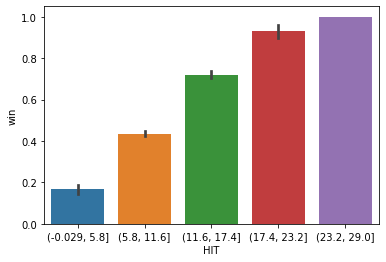

In [144]:
train['HIT'] = pd.cut(train['HIT'], 5)
sns.barplot(x='HIT', y='win', data=train);

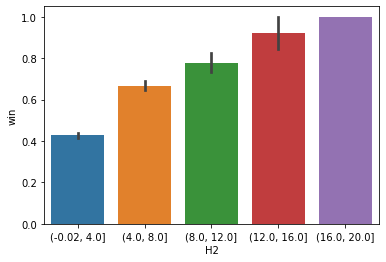

In [145]:
train['H2'] = pd.cut(train['H2'],5)
sns.barplot(x='H2', y='win', data=train);

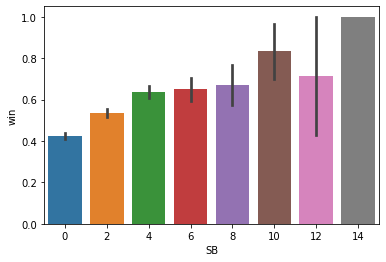

In [146]:
sns.barplot(x='SB',y='win',data=train); #타겟비율의 신뢰구간이 너무 넓음. 통계적 유효성 떨어짐. ->피처로 사용안함.

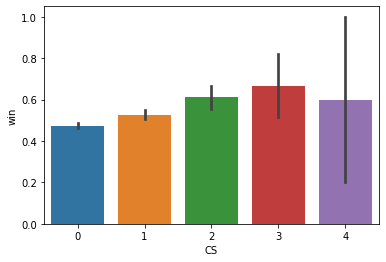

In [147]:
sns.barplot(x='CS',y='win',data=train);   #마찬가지로 제거.

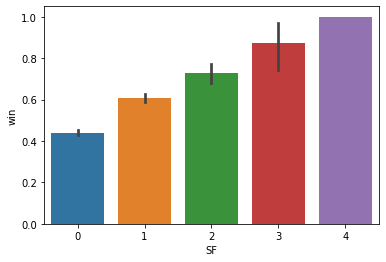

In [148]:
sns.barplot(x='SF',y='win',data=train);

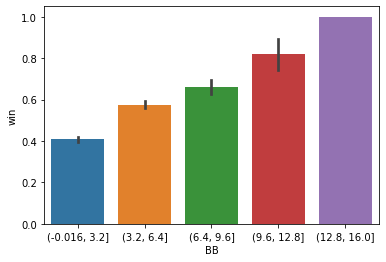

In [149]:
train['BB'] = pd.cut(train['BB'],5)
sns.barplot(x='BB',y='win',data=train);

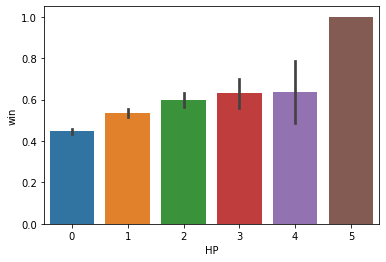

In [150]:
sns.barplot(x='HP',y='win',data=train); #신뢰구간이 넓어서 사용안함.

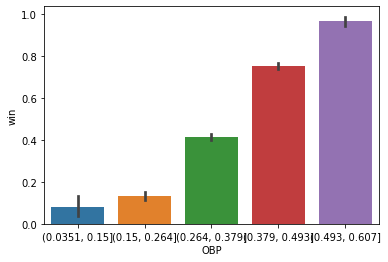

In [151]:
train['OBP'] = pd.cut(train['OBP'], 5)  #OBP,avg,slg,ops,rbi,hit,run 간의 상관관계가 너무 높음....
sns.barplot(x='OBP',y='win',data=train);

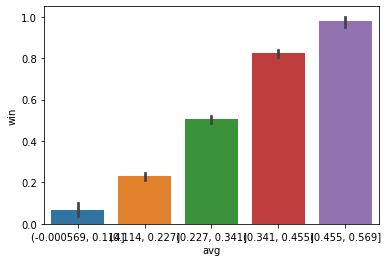

In [152]:
train['avg'] = pd.cut(train['avg'], 5) 
sns.barplot(x='avg',y='win',data=train);

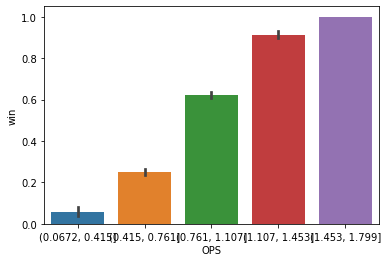

In [153]:
train['OPS'] = pd.cut(train['OPS'], 5) 
sns.barplot(x='OPS',y='win',data=train);

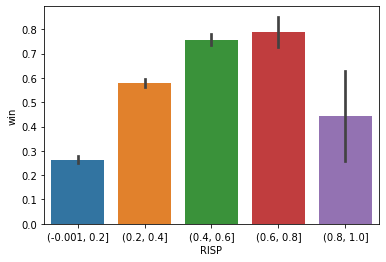

In [154]:
train['RISP'] = pd.cut(train['RISP'], 5)         #구간별 타겟값의 신뢰구간이 넓어서 사용안함.
sns.barplot(x='RISP',y='win',data=train);

In [155]:
# win 과의 상관관계 큰순서.
train.corr().loc['win'].sort_values(ascending=False)

win     1.000000
SLG     0.486945
HR      0.284498
PA      0.260922
SF      0.176544
SB      0.162616
AB      0.132928
HP      0.114651
H3      0.112419
LOB     0.112095
home    0.070942
CS      0.066652
GD     -0.066382
K      -0.189763
Name: win, dtype: float64

In [156]:
#위에서 cut 함수를 이용해서 datatype이 자동으로 카테고리컬로 바뀜. 그래서 다시 바꿔줘야함 
cat_columns = train.select_dtypes(['category']).columns
train[cat_columns] = train[cat_columns].apply(lambda x: x.cat.codes)

#모델링

## **1. 기준모델**

In [157]:
#타겟설정
target = 'win'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.50774
1    0.49226
Name: win, dtype: float64

In [158]:
#기준모델 설정. 
baseline = y_train.mode()
baseline

0    0
dtype: int64

In [159]:
#기준모델의 정확도를 구해보자.
from sklearn.metrics import accuracy_score
y_val = val[target]
y_pred = [baseline] * len(y_val)
print("기준모델 정확도: ", accuracy_score(y_val, y_pred))

기준모델 정확도:  0.5380577427821522


## **2. 로지스틱회귀모델**

In [160]:

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost.sklearn as xgb
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from eli5.sklearn import PermutationImportance


In [161]:
feature = ['HR','BB','K', 'GD', 'LOB','RISP','OBP', 'avg', 'SLG', 'OPS', 'home']

In [162]:
X_train = train[feature]
X_val = val[feature]
X_test = test[feature]
y_test =test['win']

In [164]:
#로지스틱회귀모델을 만들어 교차검증을 수행. #베이지안최적화를 사용해서 최적의 파라미터 찾아보자.

pipe_lr = make_pipeline(
    StandardScaler(),

    LogisticRegression(n_jobs=-1)
)

k = 3

scores = cross_val_score(pipe_lr, X_train, y_train, cv=k, scoring='f1')
print(f'auc for {k} folds:', scores)
print(f'교차검증 auc 평균:',scores.mean())

auc for 3 folds: [0.75736041 0.75052411 0.72472548]
교차검증 auc 평균: 0.7442033326259075


In [165]:
pipe_lr.fit(X_train,y_train);

In [166]:
y_pred = pipe_lr.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.94      0.61      0.74      1898
           1       0.30      0.80      0.43       388

    accuracy                           0.64      2286
   macro avg       0.62      0.71      0.58      2286
weighted avg       0.83      0.64      0.69      2286



In [167]:
pipe_lr.named_steps['logisticregression'].intercept_

array([-0.01158373])

In [168]:
#각 특성의 회귀계수들 
pipe_lr.named_steps['logisticregression'].coef_ 

array([[-0.05474984,  0.31079051, -0.29229654, -0.36866912, -0.43877575,
         0.28052942,  0.59862237,  0.21479218,  0.4426834 ,  0.39848575,
         0.05954395]])

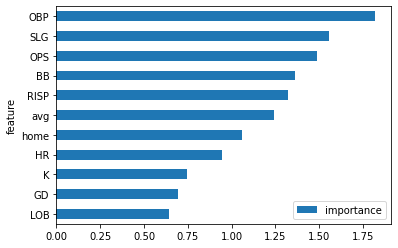

In [169]:
#로지스틱모델 회귀계수를 이용한 특성중요도.
import math
w0 = pipe_lr.named_steps['logisticregression'].intercept_[0]
w =  pipe_lr.named_steps['logisticregression'].coef_[0]

feature_importance = pd.DataFrame(feature, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)
 
from sklearn.linear_model import LogisticRegression
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()  #출루율, 타점, ops, 장타율, 볼넷, 타율, 득점권타율 순

In [223]:
#사이킷런 학습곡선함수 사용해서 모델 성능을 평가.
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


train_sizes, train_scores, val_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=5,
                               n_jobs=1, scoring='f1')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training auc')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation auc')

plt.fill_between(train_sizes,
                 val_mean + val_std,
                 val_mean - val_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('roc-auc')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

ValueError: ignored

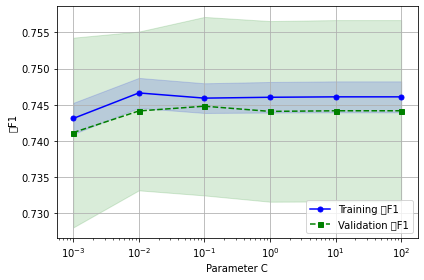

In [172]:
#검증 곡선으로 과대적합과 과소적합 조사
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, val_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=5,scoring='f1')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training F1')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, val_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation F1')

plt.fill_between(param_range, 
                 val_mean + val_std,
                 val_mean - val_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('F1')
plt.tight_layout()
plt.show()

## **3. 랜덤포레스트모델**

In [173]:
model_rf = RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)


k = 3

scores = cross_val_score(model_rf, X_train, y_train, cv=k, 
                         scoring='f1')
print(f'f1 for {k} folds:', scores)
print(f'교차검증 auc 평균:',scores.mean())

f1 for 3 folds: [0.74957756 0.73030518 0.71209801]
교차검증 auc 평균: 0.7306602500514204


In [174]:
model_rf.fit(X_train,y_train);

In [175]:
y_pred = model_rf.predict(X_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      0.54      0.70      2248
           1       0.03      0.87      0.06        38

    accuracy                           0.55      2286
   macro avg       0.51      0.71      0.38      2286
weighted avg       0.98      0.55      0.69      2286



In [176]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model, X_val, y_val):
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="g")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

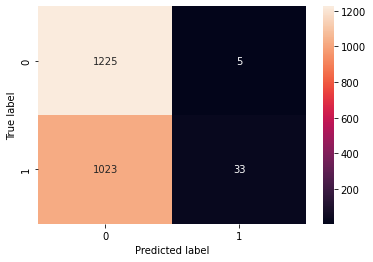

In [177]:
plot_confusion_matrix(model_rf, X_val, y_val) #애초에 모델이 balanced 모델이어서 괜찮은듯!!!

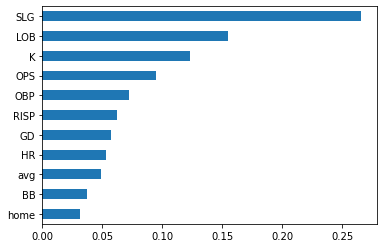

In [178]:
#MDI 특성중요도 .항상 양수값, 각 변수가 split 될 때 불순도 감소분의 평균을 중요도로 정의
importances = pd.Series(model_rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(); #장타율, 잔루, K, 타점, OPS 순으로 로지스틱과 다른양상. 

In [179]:
#Permutation importance 순열중요도


# permuter 정의
permuter_rf = PermutationImportance(
    model_rf, # model
    scoring='f1', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.


# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter_rf.fit(X_val, y_val);

In [180]:
#양수면 양의 상관관계를 나타낸다거나 음수면 음의 상관관계를 나타내는 것이 아님. 그냥 정확도가 가장 변하는 특성
feature_names = X_val.columns.tolist()
pd.Series(permuter_rf.feature_importances_, feature_names).sort_values()

LOB    -0.011546
GD     -0.003241
BB     -0.002523
OBP    -0.001771
home   -0.001101
avg     0.000000
K       0.004330
OPS     0.009959
RISP    0.012217
HR      0.018250
SLG     0.027394
dtype: float64

In [181]:
eli5.show_weights(
    permuter_rf, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0274 ± 0.0102,SLG
0.0182 ± 0.0107,HR
0.0122 ± 0.0061,RISP
0.0100 ± 0.0066,OPS
0.0043 ± 0.0048,K
0 ± 0.0000,avg
-0.0011 ± 0.0080,home
-0.0018 ± 0.0022,OBP
-0.0025 ± 0.0036,BB
-0.0032 ± 0.0062,GD


## **4. xgboost**

In [182]:
#xgboost 는 랜덤포레스트보다 하이퍼파라미터 셋팅에 민감

model_xg = XGBClassifier(random_state=2, n_jobs=-1)

k = 3

scores = cross_val_score(model_xg, X_train, y_train, cv=k, 
                         scoring='f1')
print(f'f1 for {k} folds:', scores)
print(f'교차검증 auc 평균:',scores.mean())

f1 for 3 folds: [0.75708502 0.75560224 0.72637944]
교차검증 auc 평균: 0.7463555672681427


In [183]:
#xgboost의 교차검증 auc 스코어평균이 제일 높기때문에 xgboost로 모델을 선정한다.

###하이퍼파라미터 설정


In [184]:
#하이퍼파라미터 선정을 위해서 우선 최적의 max_depth 와 estimators,learning_rate 를 찾는다.
from sklearn.metrics import roc_auc_score

depths = [1,2,3,4,5,6]
for depth in depths:
  xgb = XGBClassifier(max_depth=depth,random_state=2, n_jobs=-1,eval_metric='auc')
  xgb.fit(X_train,y_train)
  y_pred = xgb.predict(X_val)
  roc_auc = roc_auc_score(y_val,y_pred)
  print('max_depth:',depth,'auc:',roc_auc)

#최적의 max_depth = 3

max_depth: 1 auc: 0.5071022727272727
max_depth: 2 auc: 0.5445699371766446
max_depth: 3 auc: 0.588384608277901
max_depth: 4 auc: 0.5769216555801921
max_depth: 5 auc: 0.5383245565410198
max_depth: 6 auc: 0.530829637841833


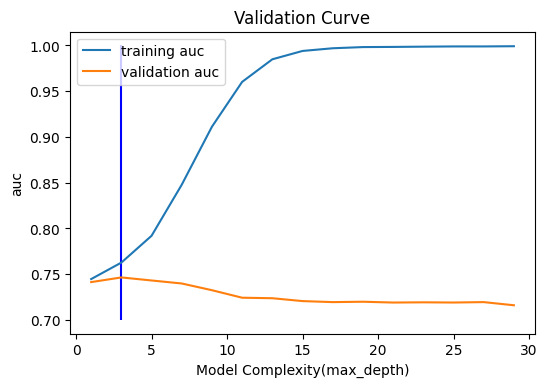

In [185]:
%matplotlib inline
#과적합을 막아줄 때 제한하는 max_depth를 변화시키며 검증곡선을 그려보자

model_xg = XGBClassifier(random_state=2, n_jobs=-1)


depth = range(1, 30, 2)
ts, vs = validation_curve(
    model_xg, X_train, y_train
    , param_name='max_depth'
    , param_range=depth, scoring='f1'
    , cv=3
    , n_jobs=-1
)

train_scores_mean = np.mean(ts, axis=1)
validation_scores_mean = np.mean(vs, axis=1)

fig, ax = plt.subplots()

# 훈련세트 검증곡선
ax.plot(depth, train_scores_mean, label='training auc')

# 검증세트 검증곡선
ax.plot(depth, validation_scores_mean, label='validation auc')

# 이상적인 max_depth
ax.vlines(3,0.7,1, color='blue')

# 그래프 셋팅
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(max_depth)', ylabel='auc')
ax.legend()
fig.dpi = 100

In [186]:
#교차검증을 통한 검증곡선으로 볼 때는 이상적인 max_depth = 3

In [187]:
estimators = [270,275,280,285]
for estimator in estimators:
  xgb = XGBClassifier(n_estimators= estimator,max_depth=3,random_state=2, n_jobs=-1,eval_metric='auc')
  xgb.fit(X_train,y_train)
  y_pred = xgb.predict(X_val)
  roc_auc = roc_auc_score(y_val,y_pred)
  print('n_estimators:',estimator,'auc:',roc_auc)
  #최적의 n_estimators = 280

n_estimators: 270 auc: 0.6256905949741316
n_estimators: 275 auc: 0.6239306171470805
n_estimators: 280 auc: 0.6257575757575757
n_estimators: 285 auc: 0.6248106060606061


In [188]:
learning_rate_value = [0.001, 0.01, 0.1, 0.15, 0.2, 0.3,0.5, 1]
for value in learning_rate_value:
  xgb = XGBClassifier(learning_rate = value,n_estimators=280, max_depth=3,random_state=2, n_jobs=-1,eval_metric='auc')
  xgb.fit(X_train,y_train)
  y_pred = xgb.predict(X_val)
  roc_auc = roc_auc_score(y_val,y_pred)
  print('learning_rate:',value,'auc:',roc_auc)
  #최적의learning_rate = 0.15

learning_rate: 0.001 auc: 0.5004734848484849
learning_rate: 0.01 auc: 0.5009469696969697
learning_rate: 0.1 auc: 0.6257575757575757
learning_rate: 0.15 auc: 0.6267438100517368
learning_rate: 0.2 auc: 0.6094974131559497
learning_rate: 0.3 auc: 0.6060582963784183
learning_rate: 0.5 auc: 0.6115530303030303
learning_rate: 1 auc: 0.5725240206947524


In [189]:
model_xg = XGBClassifier(learning_rate = 0.15,n_estimators=280,max_depth=3,random_state=2, n_jobs=-1)


params = {
    'min_child_weight': [7,8,9],
    'gamma': [0.2,0.3,0.4,0.5,0.7,0.9,1],
    'subsample': [0.5,0.6,0.7],
    'colsample_bytree': [0.6, 0.7,0.8,0.9],
    'reg_alpha': [0.5,0.6,0.7,0.8,1],
    'reg_lambda': [0.001,0.005,0.01,0.02,0.03,0.05]
    }
eval_set = [(X_train, y_train), 
            (X_val, y_val)]

fit_params={"early_stopping_rounds":10,
                "eval_metric" : "error", 
                "eval_set" : eval_set
               }

random_search = RandomizedSearchCV(model_xg,cv=5,param_distributions=params,  
                                    scoring='f1',
                                    n_jobs=10,
                                    verbose=10, 
                                     random_state=2,
                                          )

random_search.fit(X_train, y_train, **fit_params)
print("최적의 파라미터:",random_search.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-error:0.294247	validation_1-error:0.461942
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.262823	validation_1-error:0.461942
[2]	validation_0-error:0.262592	validation_1-error:0.461505
[3]	validation_0-error:0.262939	validation_1-error:0.461505
[4]	validation_0-error:0.261553	validation_1-error:0.461505
[5]	validation_0-error:0.26317	validation_1-error:0.46063
[6]	validation_0-error:0.260513	validation_1-error:0.461067
[7]	validation_0-error:0.258549	validation_1-error:0.461505
[8]	validation_0-error:0.258087	validation_1-error:0.460192
[9]	validation_0-error:0.257509	validation_1-error:0.458005
[10]	validation_0-error:0.256585	validation_1-error:0.458005
[11]	validation_0-error:0.257394	validation_1-error:0.459755
[12]	validation_0-error:0.257163	validation_1-error:0.4571

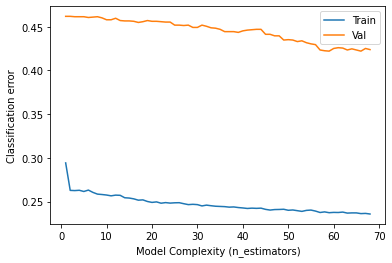

In [190]:
results = random_search.best_estimator_.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Val')
plt.ylabel('Classification error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();         

In [191]:
print('검증 정확도', random_search.best_estimator_.score(X_val, y_val))

print(classification_report(y_val, random_search.best_estimator_.predict(X_val)))

검증 정확도 0.5778652668416447
              precision    recall  f1-score   support

           0       0.56      0.99      0.72      1230
           1       0.93      0.09      0.17      1056

    accuracy                           0.58      2286
   macro avg       0.75      0.54      0.44      2286
weighted avg       0.73      0.58      0.46      2286



### 최적의 임계값

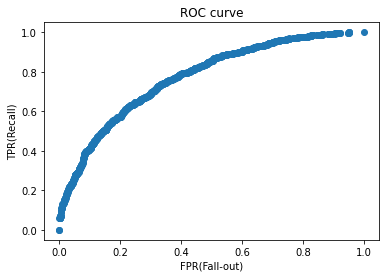

In [205]:
from sklearn.metrics import roc_curve
y_pred_proba = random_search.best_estimator_.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [206]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 514 , threshold: 0.20503531


### Feature Importance (MDI)

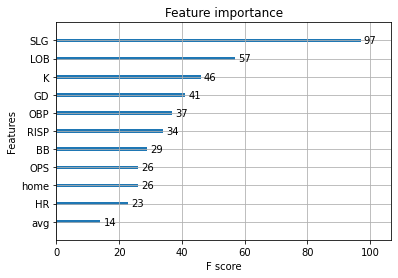

In [192]:
#MDI 특성중요도
from xgboost import plot_importance
plot_importance(random_search.best_estimator_);

### Permutation importance

In [193]:

#Permutation importance 순열중요도


# permuter 정의
permuter_xgb = PermutationImportance(
    random_search.best_estimator_, # model
    scoring='f1', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)



# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter_xgb.fit(X_val, y_val);

In [194]:
#양수면 양의 상관관계를 나타낸다거나 음수면 음의 상관관계를 나타내는 것이 아님. 그냥 정확도가 가장 변하는 특성
feature_names = X_val.columns.tolist()
pd.Series(permuter_xgb.feature_importances_, feature_names).sort_values()

GD     -0.010245
LOB    -0.009201
BB     -0.003617
OBP     0.000000
avg     0.000000
home    0.000923
HR      0.007294
OPS     0.009433
K       0.016523
RISP    0.037077
SLG     0.052640
dtype: float64

In [195]:
eli5.show_weights(
    permuter_xgb, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0526 ± 0.0144,SLG
0.0371 ± 0.0123,RISP
0.0165 ± 0.0210,K
0.0094 ± 0.0054,OPS
0.0073 ± 0.0081,HR
0.0009 ± 0.0079,home
0 ± 0.0000,avg
0 ± 0.0000,OBP
-0.0036 ± 0.0118,BB
-0.0092 ± 0.0069,LOB


### PDP

In [196]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['SLG', 'K']

interaction = pdp_interact(
    model=random_search.best_estimator_, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)

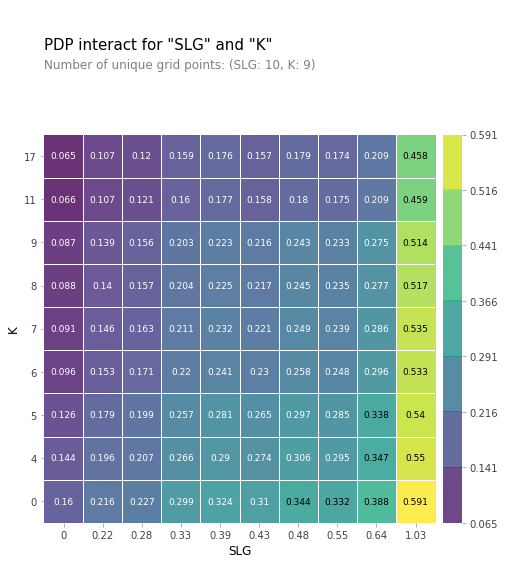

In [197]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [198]:
interaction.pdp

,SLG,K,preds
0,0.000000,0.0,0.160068
1,0.000000,4.0,0.144140
2,0.000000,5.0,0.125921
3,0.000000,6.0,0.096310
4,0.000000,7.0,0.091475
...,...,...,...
85,1.027027,7.0,0.534930
86,1.027027,8.0,0.517286
87,1.027027,9.0,0.513999
88,1.027027,11.0,0.458874


In [199]:
pdp = interaction.pdp.pivot_table(
    values='preds', # interaction['preds']
    columns=features[0], 
    index=features[1]
)[::-1]

In [200]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title='win')
    )
)

fig = go.Figure(surface, layout)
fig.show()

###SHAP

In [201]:
#SHAP 
explainer = shap.TreeExplainer(random_search.best_estimator_)
shap_values = explainer.shap_values(X_val)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=X_val
)

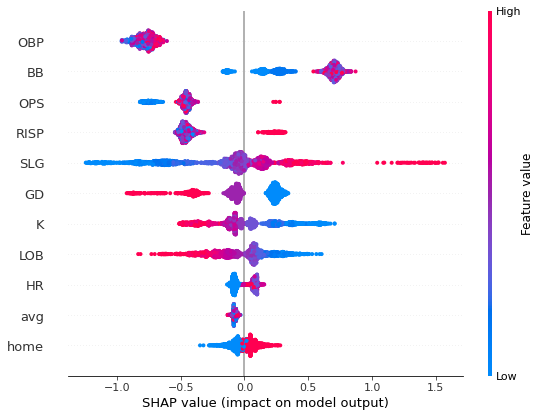

In [202]:
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)

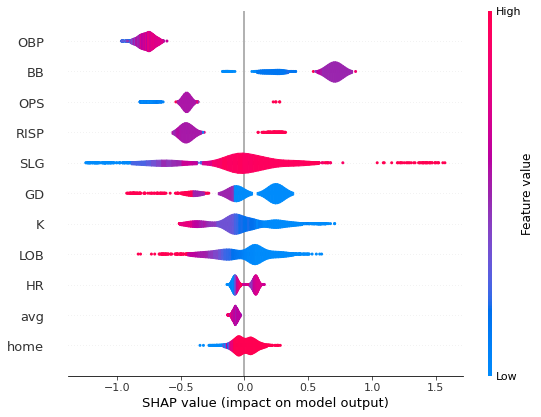

In [203]:
shap.summary_plot(shap_values, X_val, plot_type="violin")

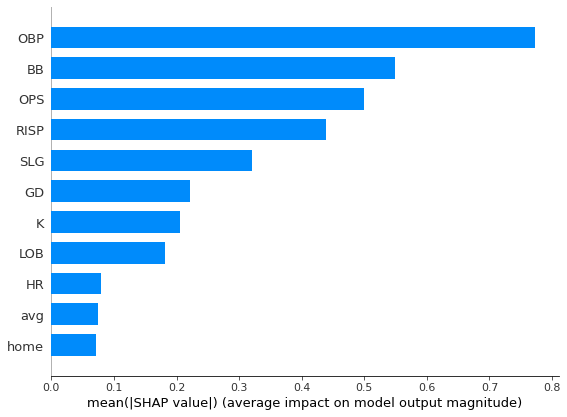

In [204]:
shap.summary_plot(shap_values, X_val, plot_type="bar")

In [207]:
from sklearn.metrics import roc_auc_score
y_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1] 
print(f'Test AUC for class "{random_search.best_estimator_.classes_[1]}":')
print(roc_auc_score(y_test, y_pred_proba)) # 범위는 0-1, 수치는 높을 수록 좋습니다

Test AUC for class "1":
0.7970732116400637


In [209]:
df_w = pd.DataFrame({ 
    'pred_proba': y_pred_proba, # 예측확률 
    'y_test': y_test # 실제값
})
df_w = X_test.join(df_w,how='left')

In [210]:
df_w

,HR,BB,K,GD,LOB,RISP,OBP,avg,SLG,OPS,home,pred_proba,y_test
10096,0,5,11,1,21,0.333333,0.365854,0.277778,0.388889,0.754743,0,0.146010,0
10097,1,3,4,2,15,0.444444,0.342857,0.281250,0.375000,0.717857,1,0.315132,1
10098,1,3,10,0,11,0.285714,0.282051,0.181818,0.393939,0.675991,0,0.277173,1
10099,0,3,10,1,13,0.000000,0.235294,0.103448,0.172414,0.407708,1,0.065242,0
10100,0,4,11,0,19,0.250000,0.325000,0.250000,0.416667,0.741667,0,0.152310,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10937,2,5,7,0,16,0.125000,0.303030,0.148148,0.370370,0.673401,1,0.354552,1
10938,2,0,6,0,16,0.500000,0.425532,0.386364,0.659091,1.084623,0,0.348998,1
10939,1,1,2,0,15,0.285714,0.277778,0.257143,0.514286,0.792063,1,0.388718,0
10940,0,1,11,0,10,0.000000,0.161290,0.133333,0.200000,0.361290,0,0.049200,0


In [246]:
win = df_w['y_test'] == 1
loss = ~win
right = (win) == (df_w['pred_proba'] > optimal_threshold)
wrong = ~right

In [248]:
#TP 이긴다고했는데 이긴경우.
df_w[win & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

,HR,BB,K,GD,LOB,RISP,OBP,avg,SLG,OPS,home,pred_proba,y_test
10743,1,1,7,0,15,0.111111,0.312500,0.290323,0.516129,0.828629,1,0.230330,1
10799,1,3,8,2,18,0.461538,0.435897,0.388889,0.694444,1.130342,1,0.275425,1
10744,2,5,9,1,19,0.375000,0.444444,0.384615,0.743590,1.188034,0,0.299299,1
10814,2,9,5,1,22,0.470588,0.528302,0.441860,0.720930,1.249232,0,0.355539,1
10885,2,4,8,0,20,0.333333,0.435897,0.371429,0.771429,1.207326,1,0.368375,1
10769,1,4,4,0,15,0.333333,0.400000,0.310345,0.551724,0.951724,1,0.417360,1
10676,2,7,5,1,21,0.500000,0.468085,0.378378,0.540541,1.008626,0,0.435024,1
10796,2,1,6,0,8,0.571429,0.307692,0.270270,0.648649,0.956341,0,0.464422,1
10920,1,4,9,1,14,0.500000,0.375000,0.305556,0.555556,0.930556,0,0.479244,1
10187,2,3,5,1,12,0.500000,0.375000,0.333333,0.722222,1.097222,1,0.544134,1


In [242]:
def explain(row_number):
    positive_class = 1
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_test.loc[[row_number]]
    

    # 예측하고 예측확률을 얻습니다 
    pred = random_search.best_estimator_.predict(row)[0]
    pred_proba = random_search.best_estimator_.predict_proba(row)[0, positive_class_index]
    def result():
      if pred_proba >= optimal_threshold:
          return '승리'
      else: '패배'  
  
    # 예측결과와 확률값을 얻습니다
    print(f'이 승패에 대한 예측결과는 {result()} 입니다.')
    
    # SHAP를 추가합니다
    shap_values = explainer.shap_values(row)

    # Fully Paid에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )

In [244]:
explain(10804)

이 승패에 대한 예측결과는 승리 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. OBP : 0.4347826086956521
2. RISP : 0.3571428571428571
3. OPS : 0.9696663296258846


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. GD : 0.0
2. BB : 2.0
3. SLG : 0.5348837209302325


#모델 평가

In [250]:
# Confution matrix를 확인해 봅시다
from sklearn.metrics import classification_report
y_test_pred_optimal = y_pred_proba >= optimal_threshold
print(f'Test AUC for class "{random_search.best_estimator_.classes_[1]}":',roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_test_pred_optimal))

Test AUC for class "1": 0.7970732116400637
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       431
           1       0.72      0.71      0.72       415

    accuracy                           0.72       846
   macro avg       0.72      0.72      0.72       846
weighted avg       0.72      0.72      0.72       846



In [257]:
#내가 만든 모델을 실제 테스트 셋에 적용하여 승패여부를 산출하고, 현재 기대순위와 실제 순위를 비교해봅니다.
df1 = test.copy()
df1 = df1.merge(df_w,how='left')
df1['pred_win'] = df1['pred_proba'] >= optimal_threshold
df1['pred_win'].map({True:1,False:0})

0      0
1      1
2      1
3      0
4      0
      ..
841    1
842    1
843    1
844    0
845    1
Name: pred_win, Length: 846, dtype: int64

In [259]:
#2022 전반기 기대순위와 기대승수.
df2 = df1.groupby(['team'])['pred_win'].sum().sort_values(ascending=False)
df2 = df2.to_frame()

In [260]:
df2['real_win'] = [57,42,52,38,54,32,35,44,36,25] #실제 승수 추가해줌

In [266]:
df2['pred_rank'] = df2['pred_win'].rank(method='min',ascending=False).astype(int)

In [272]:
df2['real_rank'] = df2['real_win'].rank(method='min',ascending=False).astype(int)

In [261]:
df2['diff'] = df2['pred_win'] - df2['real_win']

In [275]:
df2.sort_values(by='real_rank')

,pred_win,real_win,diff,pred_rank,real_rank
team,,,,,
SSG,52,57,-5,1,1
키움,41,54,-13,5,2
LG,46,52,-6,3,3
KT,36,44,-8,8,4
KIA,47,42,5,2,5
롯데,42,38,4,4,6
두산,36,36,0,8,7
삼성,37,35,2,7,8
NC,38,32,6,6,9


In [254]:
#순위에 비해 타격이 약한팀
df2.query("diff < 0").index

Index(['SSG', 'LG', '키움', 'KT'], dtype='object', name='team')

In [255]:
#순위 지표에 비해 타격이 강한팀
df2.query("diff > 0").index

Index(['KIA', '롯데', 'NC', '삼성', '한화'], dtype='object', name='team')

#프로젝트 결과

기아타이거즈의 타격지표를 통한 기대순위는 2위이다.
그러나 실제 순위는 5위이다.

상위권 팀들을 잘 살펴보면 중요한점이있다. '타격이 순위에 비해 약하다'는 특징. '타격이 순위에 비해 약하다는 것'은 어쩌면 잘못된 말일 수도 있다. 저 팀들은 타격이 아닌 다른 부분에서 강점을 보이기 때문에 순위가 높을 것이다. 

수비나 투수쪽에 약한 곳이 있고 보강이 필요한 부분이 있다면 우리는 타격이 여유가 있기 때문에 잘 비교해보고 트레이드가 가능하다. 순위에 비해 타격이 약한 팀은 키움, SSG, LG, KT 이다.
타격이 지표에비해 현저히 낮은 키움이나 KT 에서 보강할만한 투수,수비전력이 있는지 살펴본다.

상위권 팀들을 잘 살펴보면 중요한점이있다. '타격이 순위에 비해 약하다'는 특징. '타격이 순위에 비해 약하다는 것'은 어쩌면 잘못된 말일 수도 있다. 저 팀들은 타격이 아닌 다른 부분에서 강점을 보이기 때문에 순위가 높을 것이다. 

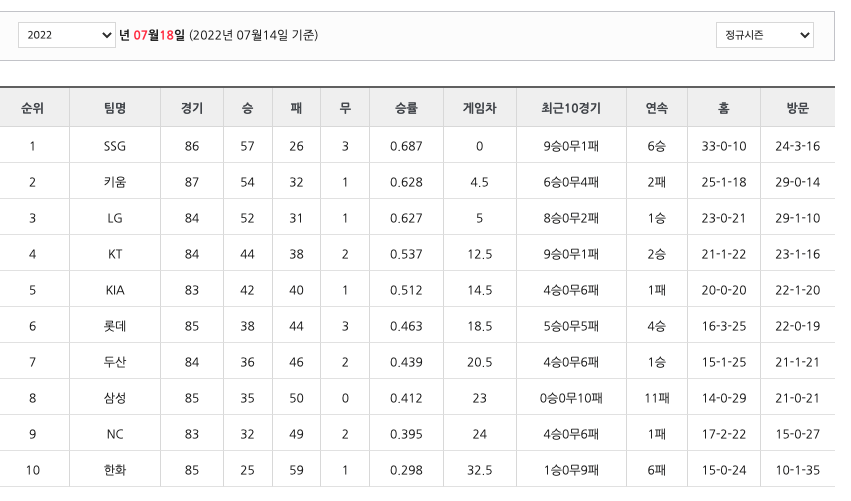